# Reducers

## Introduction
In this Jupyter Notebook we determine the best temporal reducers for leaf type mixture prediction using Sentinel 2 satellite imagery. The experiment involves processing the satellite imagery using the Google Earth Engine (GEE). Please refer to the README file in this repository for a tutorial on how to set up GEE.

## Ground Truth Label

The ground truth label is computed from the [25 ha Traunstein Forest Dynamics Plot](https://forestgeo.si.edu/sites/europe/traunstein). You can request the dataset [here](http://ctfs.si.edu/datarequest/index.php/request/form/31). Alternatively you can use the processed GeoTIFF raster "data/processed/y.tif" for the leaf type mixture label. The raster "data/processed/y_area.tif" contains the base area per leaf type.

The next cells load the dataset and analyze it.

In [1]:
# Load the data and convert it to a GeoDataFrame
import pandas as pd
import geopandas as gpd

df = pd.read_csv("../data/interim/plot.csv", parse_dates=["date"])

data = df.drop(["longitude", "latitude"], axis=1)
geometry = gpd.points_from_xy(df["longitude"], df["latitude"])
gdf = gpd.GeoDataFrame(data, crs="EPSG:4326", geometry=geometry)

gdf = gdf.to_crs("EPSG:32633")

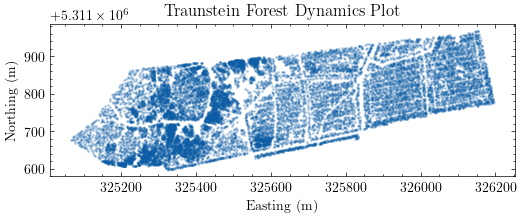

In [2]:
# Plot the data on stem level
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

ax = gdf.plot(markersize=1, figsize=(6, 2), alpha=0.25)
ax.set_title("Traunstein Forest Dynamics Plot")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
plt.show()

First sample: 2015-03-11
Last sample: 2016-04-13


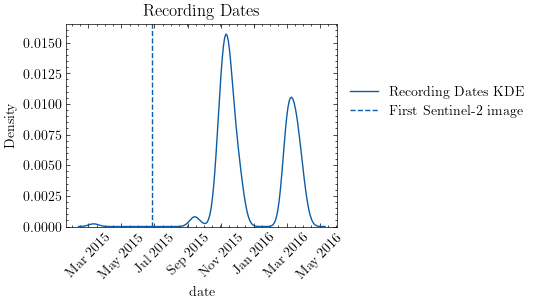

In [3]:
# Plot the distribution of the recording dates
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime

print(f"First sample: {gdf['date'].min().strftime('%Y-%m-%d')}")
print(f"Last sample: {gdf['date'].max().strftime('%Y-%m-%d')}")

ax = sns.kdeplot(gdf["date"], label="Recording Dates KDE")
ax.set_title("Recording Dates")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.axvline(datetime(2015, 6, 27), linestyle="--", label="First Sentinel-2 image")

golden_ratio = (1 + 5 ** 0.5) / 2
ax.legend(
    loc="center left",
    bbox_to_anchor=(1, 1/golden_ratio),
)

plt.show()

In [4]:
# Convert the data to two rasters
from ltm.data import compute_label
from pathlib import Path

y_path = "../data/processed/y.tif"
y_area_path = "../data/processed/y_area.tif"

if not Path(y_path).exists():
    compute_label(y_path=y_path, plot=df)

if not Path(y_area_path).exists():
    compute_label(y_path=y_area_path, plot=df, area_as_y=True)

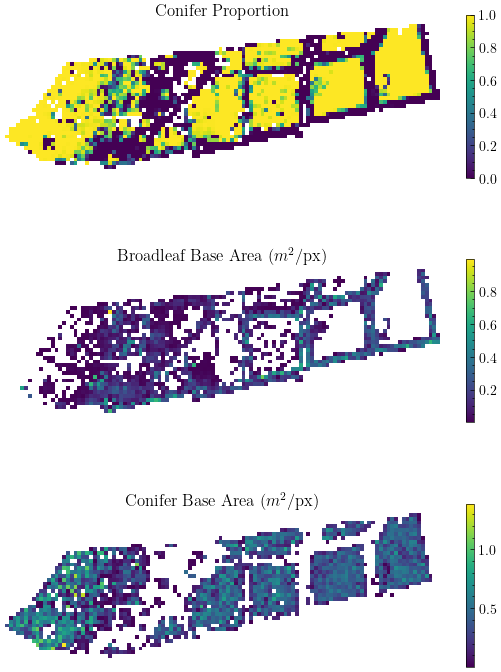

In [5]:
# Plot the two rasters, plot the base area separately per leaf type
import rasterio
import numpy as np

fig, axes = plt.subplots(3, 1, figsize=(7, 9))

with rasterio.open("../data/processed/y.tif") as src:
    # Plot the broadleaf content
    y = src.read(1)

    img = axes[0].imshow(y, cmap="viridis", interpolation="nearest")
    axes[0].set_title("Conifer Proportion")
    axes[0].axis("off")

    fig.colorbar(img, shrink=0.8)

with rasterio.open("../data/processed/y_area.tif") as src:
    # Plot the broadleaf area
    broadleaf_area = src.read(1)
    broadleaf_area[broadleaf_area == 0] = np.nan

    img = axes[1].imshow(broadleaf_area, cmap="viridis", interpolation="nearest")
    axes[1].set_title("Broadleaf Base Area ($m^2$/px)")
    axes[1].axis("off")

    fig.colorbar(img, shrink=0.8)

    # Plot the conifer area
    conifer_area = src.read(2)
    conifer_area[conifer_area == 0] = np.nan

    img = axes[2].imshow(conifer_area, cmap="viridis", interpolation="nearest")
    axes[2].set_title("Conifer Base Area ($m^2$/px)")
    axes[2].axis("off")

    fig.colorbar(img, shrink=0.8)

plt.show()

## Experiment Details
The goal the first experiment is to find the temporal reducers that are beneficial in predicting leaf type mixture as a regression problem. The experiment assumes the following:

- A time window of 1 year is chosen, starting with 1. July, 2015. This covers all seasons as well as most recording dates.
- Level-1C Sentinel 2 satellite imagery is used, as Level-2A is available only from 2017 onwards. The QA60 band is used to mask clouds. Besides that only the bands starting with a "B" are used for training and inference.
- Random Forest from scikit-learn with default parameters is chosen as the regression model.
- The evaluation metrics for the model are RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R2 (Coefficient of Determination).

The experiment is conducted on the following temporal reducers:

In [6]:
# List the available reducers
from ltm.data import list_reducers

reducers = list_reducers()
reducers

['And',
 'Or',
 'allNonZero',
 'anyNonZero',
 'circularMean',
 'circularStddev',
 'circularVariance',
 'count',
 'countDistinct',
 'countDistinctNonNull',
 'countRuns',
 'first',
 'firstNonNull',
 'kendallsCorrelation',
 'kurtosis',
 'last',
 'lastNonNull',
 'max',
 'mean',
 'median',
 'min',
 'minMax',
 'mode',
 'product',
 'sampleStdDev',
 'sampleVariance',
 'skew',
 'stdDev',
 'sum',
 'variance']

Now we can conduct the experiment. The following cell creates one raster per temporal reducer using the GEE API and stores it with the naming scheme "data/processed/X_{temporal_reducer}.tif". Each raster is then used to evaluate a random forest model using 5-fold cross validation. The results are saved to "reports/reducers.csv".

In [7]:
# Evaluate a model for each reducer
from ltm.data import list_bands, sentinel_composite
from ltm.features import load_raster, drop_nan_rows
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

reducers_path = "../reports/reducers.csv"
if not Path(reducers_path).exists():
    # Define the label path and the bands to use
    y_path = "../data/processed/y.tif"
    sentinel_bands = [band for band in list_bands() if band.startswith("B")]

    # Define the scoring metrics
    scoring = {
        "R2 Score": make_scorer(r2_score),
        "Mean Absolute Error": make_scorer(mean_absolute_error),
        "Mean Squared Error": make_scorer(mean_squared_error)
    }

    score_df = pd.DataFrame(columns=scoring.keys())
    for reducer in reducers:
        # Create the composite for current reducer
        X_path = f"../data/processed/X_{reducer}.tif"
        if not Path(X_path).exists():
            sentinel_composite(
                y_path_from=y_path,
                X_path_to=X_path,
                time_window=(datetime(2015, 7, 1), datetime(2016, 6, 30)),
                level_2a=False,
                temporal_reducers=[reducer],
                sentinel_bands=sentinel_bands,
            )

        # Load the data and drop rows containing NaNs
        X = load_raster(X_path)
        y = load_raster(y_path)
        X, y = drop_nan_rows(X, y)

        # Handle case where less than 5 samples are left (due to 5-fold cross-validation)
        if X.shape[0] < 5:
            score_df.loc[reducer] = [np.nan] * len(scoring)
            continue

        # Evaluate the model
        random_forest = RandomForestRegressor(n_jobs=-1, random_state=42)
        scores = cross_validate(random_forest, X, y, scoring=scoring, n_jobs=-1)
        score_df.loc[reducer] = [scores[f"test_{key}"].mean() for key in scoring.keys()]

    # Save the scores
    score_df.to_csv(reducers_path)
else:
    score_df = pd.read_csv(reducers_path, index_col=0)

score_df

,R2 Score,Mean Absolute Error,Mean Squared Error
And,-0.042684,0.431939,0.207988
Or,-0.042684,0.431939,0.207988
allNonZero,-0.042684,0.431939,0.207988
anyNonZero,-0.042684,0.431939,0.207988
circularMean,0.518052,0.216743,0.096471
circularStddev,0.347487,0.270917,0.131086
circularVariance,0.352619,0.269755,0.130040
count,-0.054206,0.424003,0.209965
countDistinct,0.010798,0.397285,0.197538
countDistinctNonNull,0.010798,0.397285,0.197538


To decide which temporal reducers are suitable for the task, we (arbitrarily) choose the following criteria:
- The $R^2$ score must be at least 0.05

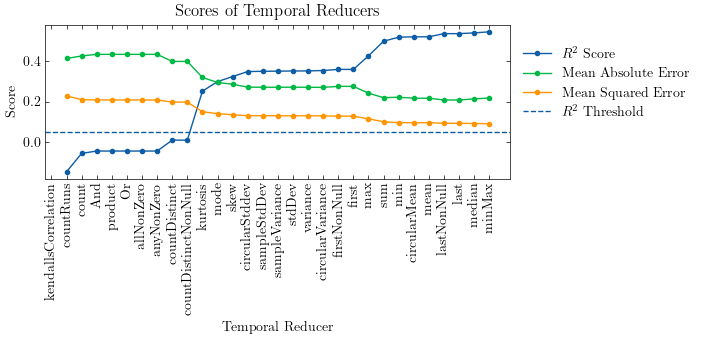

In [8]:
# Plot the scores with a line plot, with the rows sorted by R2 score
score_df = score_df.sort_values("R2 Score", na_position="first")

ax = score_df.plot(figsize=(6, 2), marker=".")
ax.axhline(0.05, linestyle="--", label="$R^2$ Threshold")

ax.set_title("Scores of Temporal Reducers")
ax.set_xlabel("Temporal Reducer")
ax.set_ylabel("Score")

ax.set_xticks(range(len(score_df)))
ax.set_xticklabels(score_df.index, rotation=90)
ax.minorticks_off()

labels = ax.get_legend_handles_labels()[1]
labels[labels.index("R2 Score")] = "$R^2$ Score"
ax.legend(labels, loc="center left", bbox_to_anchor=(1, 1/golden_ratio))
plt.show()

# Result

The following temporal reducers are considered suitable for the task and are used for the next experiment:

In [15]:
for reducer in sorted(score_df[score_df["R2 Score"] >= 0.05].index):
    print(reducer)

circularMean
circularStddev
circularVariance
first
firstNonNull
kurtosis
last
lastNonNull
max
mean
median
min
minMax
mode
sampleStdDev
sampleVariance
skew
stdDev
sum
variance
